In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from PIL import Image

# Check device
print(f"TensorFlow is using: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")


TensorFlow is using: GPU


In [18]:
# Preprocess function for VGG19
def load_and_process_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((512, 512))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)  # VGG19-specific preprocessing
    return tf.convert_to_tensor(img)

# Deprocess to view images
def deprocess_image(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Paths
content_path = "/content/closeup-scarlet-macaw-from-side-view-scarlet-macaw-closeup-head.jpg"
style_path = "/content/closeup-shot-beautiful-butterfly-with-interesting-textures-orange-petaled-flower.jpg"

# Load images
content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)


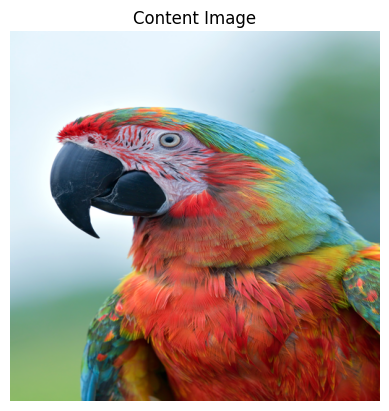

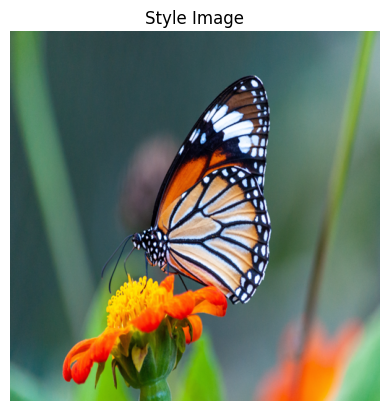

In [19]:
def show_image(image, title=None):
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    plt.imshow(deprocess_image(image))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Show content and style images
show_image(content_image, title="Content Image")
show_image(style_image, title="Style Image")


In [20]:
# Content and Style layer names from VGG19
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Total number of layers
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Build model to output selected layers
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    model = Model(inputs=vgg.input, outputs=outputs)
    return model


In [21]:
# Compute Gram matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations


In [22]:
# Extract style and content features
def get_feature_representations(model, content_img, style_img):
    content_img = tf.cast(content_img, tf.float32)
    style_img = tf.cast(style_img, tf.float32)

    # batch compute outputs
    style_outputs = model(style_img)
    content_outputs = model(content_img)

    # Separate outputs
    style_features = [style_layer for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer for content_layer in content_outputs[num_style_layers:]]

    return style_features, content_features


In [23]:
# Loss function
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    # Style Loss
    style_score = 0
    content_score = 0

    # Calculate style loss
    weight_per_style_layer = 1.0 / num_style_layers
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        gram_comb_style = gram_matrix(comb_style)
        style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram_comb_style - target_style))

    # Calculate content loss
    weight_per_content_layer = 1.0 / num_content_layers
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * tf.reduce_mean(tf.square(comb_content - target_content))

    # Total loss
    style_score *= style_weight
    content_score *= content_weight
    total_loss = style_score + content_score
    return total_loss, style_score, content_score


In [24]:
# Training function
@tf.function()
def train_step(init_image, model, loss_weights, gram_style_features, content_features, optimizer):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(model, loss_weights, init_image, gram_style_features, content_features)
    loss = all_loss[0]
    grads = tape.gradient(loss, init_image)
    optimizer.apply_gradients([(grads, init_image)])
    init_image.assign(tf.clip_by_value(init_image, -103.939, 255.0-103.939))  # clip
    return all_loss


In [25]:
def run_style_transfer(content_path, style_path, num_iterations=1000,
                       content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_image = load_and_process_image(content_path)
    style_image = load_and_process_image(style_path)

    # Feature representations
    style_features, content_features = get_feature_representations(model, content_image, style_image)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Initialize generated image
    init_image = tf.Variable(content_image, dtype=tf.float32)

    # Optimizer
    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    # Weights
    loss_weights = (style_weight, content_weight)

    best_loss, best_img = float('inf'), None
    display_interval = 100

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    for i in range(num_iterations):
        loss, style_score, content_score = train_step(
            init_image, model, loss_weights, gram_style_features, content_features, optimizer
        )

        if (i+1) % display_interval == 0:
            print(f"Iteration {i+1}: Total loss: {loss.numpy():.4e}, Style loss: {style_score.numpy():.4e}, Content loss: {content_score.numpy():.4e}")

        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()

    return best_img

In [26]:
stylized_image = run_style_transfer(content_path, style_path, num_iterations=500)


Iteration 100: Total loss: 1.6417e+06, Style loss: 9.5840e+05, Content loss: 6.8328e+05
Iteration 200: Total loss: 1.1936e+06, Style loss: 6.6692e+05, Content loss: 5.2670e+05
Iteration 300: Total loss: 1.0462e+06, Style loss: 5.6984e+05, Content loss: 4.7631e+05
Iteration 400: Total loss: 2.1546e+06, Style loss: 1.4996e+06, Content loss: 6.5499e+05
Iteration 500: Total loss: 8.3426e+05, Style loss: 4.3368e+05, Content loss: 4.0058e+05


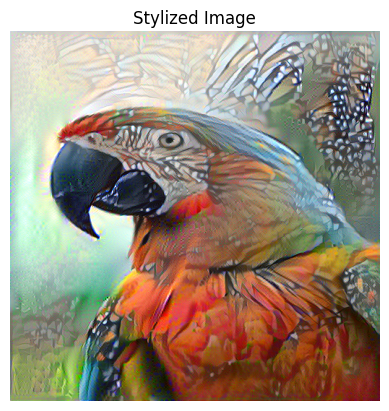

In [27]:
show_image(stylized_image, title='Stylized Image')
